- KEYWORDS: scipy.optimize.minimize, scipy.optimize.curve_fit, pycse.nlinfit


## Regression of data is a form of function minimization



When we say regression, we really mean find some parameters of a model that best reproduces some known data. By "best reproduces" we mean the sum of all the errors between the values predicted by the model, and the real data is minimized.

Suppose we have the following data that shows how the energy of a material depends on the volume of the material.



# Out [1]:
# text/plain
Text(0, 0.5, 'E')

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

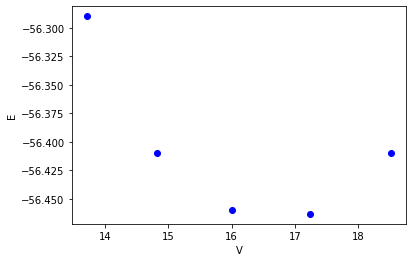

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

volumes = np.array([13.71, 14.82, 16.0, 17.23, 18.52])
energies = np.array([-56.29, -56.41, -56.46, -56.463,-56.41])

plt.plot(volumes, energies, 'bo')
plt.xlabel('V')
plt.ylabel('E')

In Materials Science we often want to fit an equation of state to this data. We will use this equation:

$E = E_0 + \frac{B_0 V}{B_0'}\left(\frac{(V_0 / V)^{B_0'}}{B_0' - 1} + 1 \right) - \frac{V_0 B_0}{B_0' - 1}$

from [https://journals.aps.org/prb/pdf/10.1103/PhysRevB.28.5480](https://journals.aps.org/prb/pdf/10.1103/PhysRevB.28.5480). In this model there are four parameters:

| name|desc|
|---|---|
| E\_0|energy at the minimim|
| B\_0|bulk modulus|
| B\_0'|first derivative of the bulk modulus|
| V\_0|volume at the energy minimum|

We would like to find the value of these parameters that best fits the data above. That means, find the set of parameters that minimize the sum of the squared errors between the model and data.

First we need a function that will use the parameters and return the energy for a given volume.



In [1]:
def Murnaghan(parameters, vol):
    'From PRB 28,5480 (1983)'
    E0, B0, BP, V0 = parameters
    E = E0 + B0 * vol / BP * \
        (((V0 / vol)**BP) / (BP - 1) + 1) - V0 * B0 / (BP - 1.)

    return E

# Out [11]:

Next, we need a function that computes the summed squared errors for a set of parameters. The use of squared errors is preferable in many cases to the absolute values because it has a continuous derivative. We will learn more about this later.



In [1]:
def objective(pars):
    err = energies - Murnaghan(pars, volumes)
    return np.sum(err**2)  # we return the summed squared error directly

# Out [12]:

Finally,  we need an initial guess to start the minimization. As with all minimization problems, this can be the most difficult step. It is always a good idea to use properties of the model and data where possible to make these guesses. We have no way to plot anything in four dimensions, so we use analysis instead.

We can derive some of these from the data we have. First, we can get the minimum in energy and the corresponding volume that we know from the data. These are not the final answer, but they are a good guess for it.

The B<sub>0</sub> parameter is related to the curvature at the minimum, which is the second derivative. We get that from repeated calls to `numpy.gradient`. Finally, $B_0'$ is related to the derivative of $B$ at the minimum, so we estimate that too.



In [1]:
imin = np.argmin(energies)
dedv = np.gradient(energies, volumes)
B = np.gradient(dedv, volumes)
Bp = np.gradient(B, volumes)


x0 = [energies[imin],
      B[imin],
      Bp[imin],
      volumes[imin]]

x0

# Out [13]:
# text/plain
[-56.463, 0.02575384116153356, -0.00900405886406903, 17.23]

Finally, we are ready to fit our function. As usual, we also plot the data and the fit for visual inspection.



# Out [14]:
# output
#+BEGIN_EXAMPLE
      fun: 1.4912965344598558e-05
 hess_inv: array([[ 3.03863745e-01, -3.02573371e+00,  8.04371522e+01,
        -2.41676767e+00],
       [-3.02573371e+00,  5.27761683e+01, -1.63584644e+03,
         4.76079594e+01],
       [ 8.04371522e+01, -1.63584644e+03,  7.06615880e+04,
        -2.81868629e+03],
       [-2.41676767e+00,  4.76079594e+01, -2.81868629e+03,
         1.54690538e+02]])
      jac: array([ 3.46717718e-06,  1.36594349e-06,  7.79607490e-09, -5.30043053e-07])
  message: 'Optimization terminated successfully.'
     nfev: 216
      nit: 31
     njev: 36
   status: 0
  success: True
        x: array([-56.46839794,   0.57236216,   2.74084063,  16.55900277])
#+END_EXAMPLE


# text/plain
Text(0, 0.5, 'E')

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

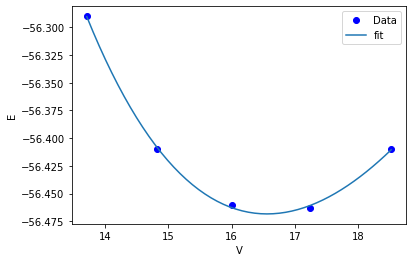

In [1]:
from scipy.optimize import minimize
sol = minimize(objective, x0)
print(sol)

plt.plot(volumes, energies, 'bo', label='Data')
vfit = np.linspace(min(volumes), max(volumes))
plt.plot(vfit, Murnaghan(sol.x, vfit), label='fit')
plt.legend()
plt.xlabel('V')
plt.ylabel('E')

That looks pretty good. We should ask ourselves, how do we know we got a minimum? We should see that the objective function is really at a minimum *for each of the parameters*. Here, we show that it is a minimum for the first parameter.



# Out [15]:
# text/plain
Text(0, 0.5, 'summed squared error')

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

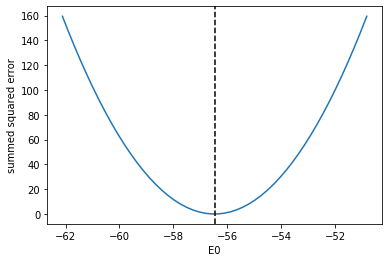

In [1]:
E0_range = np.linspace(0.9 * sol.x[0], 1.1 * sol.x[0])

errs = [objective([e0, *sol.x[1:]]) for e0 in E0_range]

plt.plot(E0_range, errs)
plt.axvline(sol.x[0], c='k', ls='--')
plt.xlabel('E0')
plt.ylabel('summed squared error')

You can see visually that the error goes up on each side of the parameter estimate.

**exercise** Repeat this analysis for the other three parameters.

Later when we learn about linear algebra, we will learn that if you can show the eigenvalues of the Hessian of the objective function is positive definite, that also means you are at a minimum. It means the error goes up in any direction away from the minimum.

Usually we do some regression to find one of these:

1.  Parameters for the model - because the parameters mean something
2.  Properties of the model - because the properties mean something

In this particular case, we can do both. Some of the parameters are directly meaningful, like the E0, and V0 are the energy at the minimum, and the corresponding volume. B0 is also meaningful, it is called the bulk modulus, and it is a material property.

Now that we have a model though we can also define properties of it, e.g. *in this case* we have from thermodynamics that $P = -dE/dV$. We can use our model to define this derivative. I use `scipy.misc.derivative` for this for convenience. The only issue with it is the energy function has arguments that are not in the right order for the derivative, so I make a proxy function here that just reverses the order of the arguments.



In [1]:
from scipy.misc import derivative

pars = sol.x
def P(V):
    def proxy(V, pars):
        return Murnaghan(pars, V)
    dEdV = derivative(proxy, V, args=(pars,), dx=1e-6)
    return -dEdV

# Some examples
P(16), P(pars[-1]), P(18)

# Out [16]:
# text/plain
(0.020610354312111667, -0.0, -0.04269126563372083)

The result above shows that it takes positive pressure to compress the material, the pressure is zero at the minimum, and it takes negative pressure to cause it to expand.

This example is just meant to illustrate what one can do with a model once you have it.



## Parameter confidence intervals



We have left out an important topic in the discussion above: How certain are we of the parameters we estimated? This is a complicated question that requires moderately sophisticated statistics to answer. We will build up to the solution in steps.

First, we recall that in a statistical sense we are *estimating* the values of the parameters. Specifically, we estimate the *mean* of the parameters, from a fixed number of data points.

Let's say we have made 10 measurements that have an average of 16.1, and a standard deviation of 0.01. What is the range of values that we are 95% confident the next measurement will fall in?

We have to take into account the fact that we only have 10 measurements to make the estimation from, so the estimate is more uncertain than if we have 100 or 1000 measurements. The student t-tables tell us precisely how much more uncertain depending on the confidence level you want.

The point here is not for you to memorize or derive these formulas, only to illustrate that the uncertainty is not simply the standard deviation. It also includes the effect of the sample size.



In [1]:
from scipy.stats.distributions import t

n = 10  # number of measurements
dof = n - 1  # degrees of freedom
avg_x = 16.1  # average measurement
std_x = 0.01  # standard deviation of measurements

# Find 95% prediction interval for next measurement
alpha = 1.0 - 0.95

pred_interval = t.ppf(1 - alpha / 2.0, dof) * std_x / np.sqrt(n)

plus_side = avg_x + pred_interval
minus_side = avg_x - pred_interval

print(f'We are 95% confident the next measurement will be between {minus_side:1.3f} and {plus_side:1.3f}')

# Out [17]:
# output
We are 95% confident the next measurement will be between 16.093 and 16.107

To consider the uncertainty in model parameters, we need some way to estimate the standard deviation of the parameters. `scipy.optimize.minimize` does not provide much help with that. We will instead turn to `scipy.optimize.curve_fit`. This function will return information that is helpful in estimating the uncertainty. It is like `scipy.optimize.minimize` in the sense that it minimizes the summed squared errors between a model described in a function, and data defined in variables. Note in particular the docstring for the output variable pcov, which tells you how to compute the standard deviation errors on the parameters.



In [1]:
import numpy as np
from scipy.optimize import curve_fit

curve_fit?

# Out [18]:

### An example with curve_fit



Given the data below, fit the following curve:

$y(x) = \frac{a x}{b + x}$ to it.

That means, estimate the values of $a, b$ that best fit the data.



# Out [19]:
# text/plain
Text(0, 0.5, 'y')

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

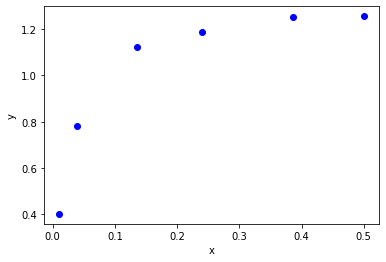

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

x = np.array([0.5, 0.387, 0.24, 0.136, 0.04, 0.011])
y = np.array([1.255, 1.25, 1.189, 1.124, 0.783, 0.402])

plt.plot(x, y, 'bo')
plt.xlabel('x')
plt.ylabel('y')

What should we use for an initial guess? At $x=0$, $y = 0$, which isn't that helpful. At large $x$, we have $y=a$. From the data, we can guess that $a \approx 1.2$. For small x, we have $y = a/b x$. So, if we estimate the slope, we can estimate b. We arrive at these guesses by thoughtful inspection of the data, and the model that we use to fit it.



In [1]:
a0 = 1.2
m = np.gradient(y, x, edge_order=2) # m = a / b  ->  b = a / m

b0 = a0 / m[-1]
a0, b0

# Out [20]:
# text/plain
(1.2, 0.0781156032363354)

Now for the fitting.



In [1]:
# this is the function we want to fit to our data
def func(x, a, b):
    return a * x / (b + x)

initial_guess = [a0, b0]
pars, pcov = curve_fit(func, x, y, p0=initial_guess)

pars, pcov

# Out [21]:
# text/plain
(array([1.32753143, 0.02646156]),
 array([[9.45332917e-05, 7.10675655e-06],
        [7.10675655e-06, 1.05658850e-06]]))

*Always* check the fit visually.



# Out [22]:


# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

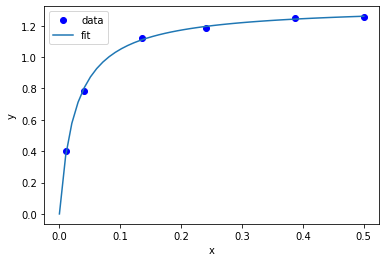

In [1]:
plt.plot(x, y, 'bo')
xfit = np.linspace(0, 0.5)
plt.plot(xfit, func(xfit, *pars))
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['data', 'fit'])

**exercise** Try different initial guesses and find one that does not look this good.



### Uncertainty estimation



Recall from the documentation of curve\_fit that the standard deviation of each parameter is defined by:



In [1]:
np.sqrt(np.diag(pcov))

# Out [23]:
# text/plain
array([0.00972282, 0.0010279 ])

We can use these to estimate confidence intervals on the two parameters. Note that here we still use the student-t multipliers to account for the uncertainty caused by having a small data set.



In [1]:
from scipy.stats.distributions import t

alpha = 0.05  # 95% confidence interval = 100*(1-alpha)

n = len(y)    # number of data points
p = len(pars)  # number of parameters

dof = max(0, n - p)  # number of degrees of freedom

# student-t value for the dof and confidence level
tval = t.ppf(1.0 - alpha / 2., dof)

for i, p, var in zip(range(n), pars, np.diag(pcov)):
    sigma = var**0.5
    print(f'p{i}: {p:1.2f} [{p - sigma * tval:1.3f}  {p + sigma * tval:1.3f}]')

# Out [24]:
# output
p0: 1.33 [1.301  1.355]
p1: 0.03 [0.024  0.029]

The interpretation of this is that we do not know exactly what the parameters are, but we can be 95% confident that they fall in these ranges. These ranges do not include zero, so that is an indication that the parameters are significant.

It is *not expected* that you learn all the details above. They have been coded into the "Python computations in science and engineering" [pycse](https://kitchingroup.cheme.cmu.edu/pycse/) package. This is not part of Anaconda; you have to install it yourself. This code block should do that and install some dependencies (you only need to run it once).



In [1]:
!pip install uncertainties
!pip install quantities
!pip install pycse

# Out [25]:
# output

After that, you can import the nlinfit command and use it to get confidence intervals directly.



In [1]:
from pycse import nlinfit

nlinfit?

# Out [30]:

In [1]:
pars, pars_ci, se = nlinfit(func, x, y, [a0, b0])

for i, par in enumerate(pars):
    print(f'{par:1.3f}, {np.round(pars_ci[i], 3)}, {se[i]:1.4f}')

# Out [31]:
# output
1.328, [1.301 1.355], 0.0097
0.026, [0.024 0.029], 0.0010

It is important to realize that:

1.  The size of the confidence interval depends on the number of parameters, data points, and desired confidence level.
2.  The root of this is the minimization of an error function.



### What about uncertainty on the predictions?



Consider the fit again, and extrapolate it to larger $x$:



# Out [32]:
# text/plain
1.3205427044923441

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

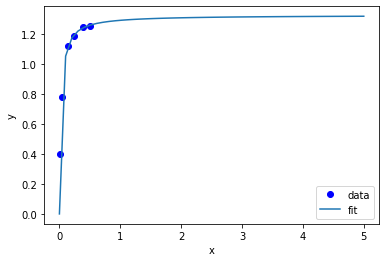

In [1]:
plt.plot(x, y, 'bo')
xfit = np.linspace(0, 5)
plt.plot(xfit, func(xfit, *pars))
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['data', 'fit'])
func(xfit, *pars)[-1]

We estimate the model plateaus at about y=1.32, but what is an appropriate estimate of the error in this? There are uncertainties in the model parameters, so there must be uncertainty in the predictions. To estimate this, we first look at how to generate a distribution of random numbers with a normal distribution around some mean with some standard error.



# Out [33]:
# text/plain
(array([  3.,   2.,  14.,  39.,  87., 217., 318., 484., 665., 715., 726.,
        651., 466., 286., 180.,  98.,  35.,   9.,   3.,   2.]),
 array([1.29158995, 1.29523556, 1.29888117, 1.30252679, 1.3061724 ,
        1.30981801, 1.31346363, 1.31710924, 1.32075486, 1.32440047,
        1.32804608, 1.3316917 , 1.33533731, 1.33898292, 1.34262854,
        1.34627415, 1.34991977, 1.35356538, 1.35721099, 1.36085661,
        1.36450222]),
 <a list of 20 Patch objects>)

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

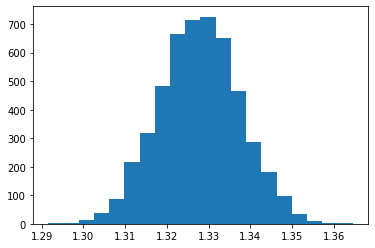

In [1]:
p0_mean = pars[0]
p0_se = se[0]

p0_dist = np.random.normal(p0_mean, p0_se, 5000)
plt.hist(p0_dist, bins=20)

So the idea is we can generate a distribution of the parameters



# Out [34]:
# text/plain
(1.3208054619634086, 0.009597123012463358)

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

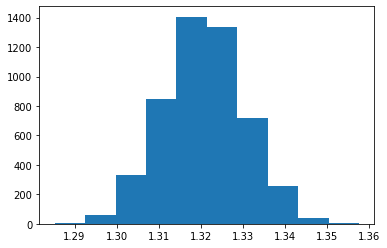

In [1]:
p1_dist = np.random.normal(pars[1], se[1], 5000)

y5 = [func(5, p0, p1) for p0, p1 in zip(p0_dist, p1_dist)]
plt.hist(y5)

np.mean(y5), np.std(y5)

Well, in 20/20 hindsight, we might have guessed the uncertainty in the asymptote would be just like the uncertainty in the $a$ parameter. In this case, it is appropriate to use three significant figures given the uncertainty on the answer. A useful guideline is that the 95% confidence interval is about &plusmn; 2 &sigma;. At &plusmn; 1 &sigma; you only have about a 60% confidence interval.



In [1]:
print(f'At x=5, y={np.mean(y5):1.3f} +- {2 * np.std(y5):1.3f} at about the 95% confidence level.')

# Out [35]:
# output
At x=5, y=1.321 +- 0.019 at about the 95% confidence level.

So we are not that uncertain after all in this case.

This method of error propagation is not perfect as it assumes the errors between the parameters are independent, and that they are normally distributed. However, the method is very simple to do, and simply relies on sampling the parameters from their respective distributions, and letting the results propagate naturally through the model. You do need to check for convergence with the sample size. This method is called a Monte Carlo propagation of errors.



## Summary



We covered a lot of ground today. The key points are:

1.  Regression is a minimization of an accumulated error function.
2.  If you need uncertainty on the parameters from a regression, use `pycse.nlinfit`.
3.  If you need uncertainty on model predictions, you can either simulate it, or derive it. We will learn more about deriving it later.

